In [306]:
%matplotlib inline

In [307]:
import netCDF4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import time
from mpl_toolkits.basemap import Basemap
import imageio
from sklearn import neighbors, datasets, cluster
import cv2

In [308]:
data = netCDF4.Dataset('data/G10010_SIBT1850_v1.1.nc', 'r', format='NETCDF4')
lon = data['longitude']
lat = data['latitude']
time = data['time']
conc = data['seaice_conc']

**Reducing dimensionality of variables** 

Longitude and latitude reduced by a factor of 10

Time passed from days to months (roughly, reduced by a factor of 24)

In [309]:
def red_dim_basics(lon, lat, time):
    print 'Prior dimensions:'
    print '\t Longitude: ', lon.shape
    print '\t Latitude: ', lat.shape
    print '\t Timme: ', time.shape

    lon = lon[::10]
    lat = lat[::10]
    time = time[::24]

    print 'Posterior dimensions:'
    print '\t Longitude: ', lon.shape
    print '\t Latitude: ', lat.shape
    print '\t Time: ', time.shape
    
    return lon, lat, time


In [310]:
def red_dim_conc_2D(idx, conc):
    conc2D = conc[idx,:,:]
    
    print 'Prior dimensions:'
    print '\t Ice concentration: ', conc2D.shape

    step = 10
    f_conc = np.zeros((24,144))
    for idx in range(0,240,step):
        for jdx in range(0,1440,step):
            f_conc[idx/step, jdx/step] = np.median(conc2D[idx:idx+step,jdx:jdx+step])
        
    print 'Posterior dimensions:'
    print '\t Ice concentration: ', f_conc.shape
    
    return f_conc
    

In [316]:
def red_dim_conc_3D(conc):
    
    print 'Prior dimensions:'
    print '\t Ice concentration: ', conc.shape

    step_l = 10
    step_t = 24
    f_conc = np.zeros((1968,24,144))
    for idx in range(0,240,step_l):
        for jdx in range(0,1440,step_l):
            for kdx in range(0,1968,step_t):
                f_conc[kdx/step_t,idx/step_l, jdx/step_l] = \
                np.median(conc[kdx:kdx+step_t,idx:idx+step_l,jdx:jdx+step_l])
        
    print 'Posterior dimensions:'
    print '\t Ice concentration: ', f_conc.shape
    
    return f_conc
    

In [312]:
lon, lat, time = red_dim_basics(lon, lat, time)
conc2D = red_dim_conc_2D(0,conc)

Prior dimensions:
	 Longitude:  (1440,)
	 Latitude:  (240,)
	 Timme:  (1968,)
Posterior dimensions:
	 Longitude:  (144,)
	 Latitude:  (24,)
	 Time:  (82,)
Prior dimensions:
	 Ice concentration:  (240, 1440)
Posterior dimensions:
	 Ice concentration:  (24, 144)


In [ ]:
conc = red_dim_conc_3D(conc)

Prior dimensions:
	 Ice concentration:  (1968, 240, 1440)


**Ploting the reduced dimensionality data**

In [246]:
def plot_contour_arctic_3D(idx):
    plt.clf
    plt.figure(1, figsize=(12,10))

    levels = np.arange(0, 100, 10)

    lat_min = 41.0
    lat_max = 71.0
    lon_min = -180
    lon_max = 180

    m = Basemap(width=10.e6, height=11.e6,
                projection='gnom', lat_0=88.0, lon_0=-30.0)

    x, y = m(*np.meshgrid(lon[:], lat[:]))
    m.drawcoastlines(color='black')
    m.fillcontinents(color='gray')

    m.drawmeridians(np.arange(np.min(lon), np.max(lon), 20),labels=[0,0,0,1])
    m.drawparallels(np.arange(lat_min, lat_max,10),labels=[1,0,0,0])

    CS1 = m.contourf(x,y,conc[idx,:,:],
                     levels,cmap=plt.get_cmap('RdYlBu_r',len(levels)-1),
                     extend='max')
    CS1.axis='tight'
    plt.colorbar(CS1,orientation='vertical',extend='max', shrink=0.5)
    plt.ion()
    plt.title('Ice concentration in the artic: Sample #' + str(idx))
    #plt.savefig('images2/'+str(idx)+'.png')
    plt.show()
    plt.close()

In [247]:
def plot_contour_arctic_2D(conc):
    plt.clf
    plt.figure(1, figsize=(12,10))

    levels = np.arange(0, 100, 10)

    lat_min = 41.0
    lat_max = 71.0
    lon_min = -180
    lon_max = 180

    m = Basemap(width=10.e6, height=11.e6,
                projection='gnom', lat_0=88.0, lon_0=-30.0)

    x, y = m(*np.meshgrid(lon[:], lat[:]))
    m.drawcoastlines(color='black')
    m.fillcontinents(color='gray')

    m.drawmeridians(np.arange(np.min(lon), np.max(lon), 20),labels=[0,0,0,1])
    m.drawparallels(np.arange(lat_min, lat_max,10),labels=[1,0,0,0])

    CS1 = m.contourf(x,y,conc,
                     levels,cmap=plt.get_cmap('RdYlBu_r',len(levels)-1),
                     extend='max')
    CS1.axis='tight'
    plt.colorbar(CS1,orientation='vertical',extend='max', shrink=0.5)
    plt.ion()
    plt.title('Ice concentration in the artic: Sample #' + str(idx))
    #plt.savefig('images2/'+str(idx)+'.png')
    plt.show()
    plt.close()

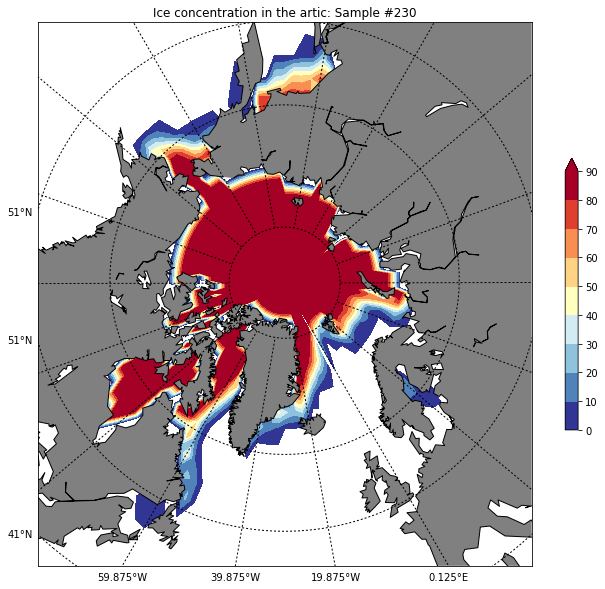

In [248]:
plot_contour_arctic_2D(conc2D)

**Prepare gif**

In [ ]:
length = time.shape[0]
for idx in range(0,length-1):
    plot_contour_arctic_3D(idx)

In [ ]:
filenames = []
for idx in range(0,length):
    filenames.append('images2/'+str(idx)+'.png')
with imageio.get_writer('vid2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

**KNN time :)**


In [275]:
conc2D_l = conc2D[:,:].ravel()
conc2D_l = np.reshape(conc2D_l, (-1, 1))
nbrs = neighbors.NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(conc2D_l)
distances, indices = nbrs.kneighbors(conc2D_l)

In [293]:
lbls_ndim = []
for idx in range(0, time.shape[0])
    clt = cluster.SpectralClustering(n_clusters=50, n_neighbors=15, n_jobs=-1)
    lbls = clt.fit_predict(conc2D_l)
    lbls = lbls.reshape(24,144)

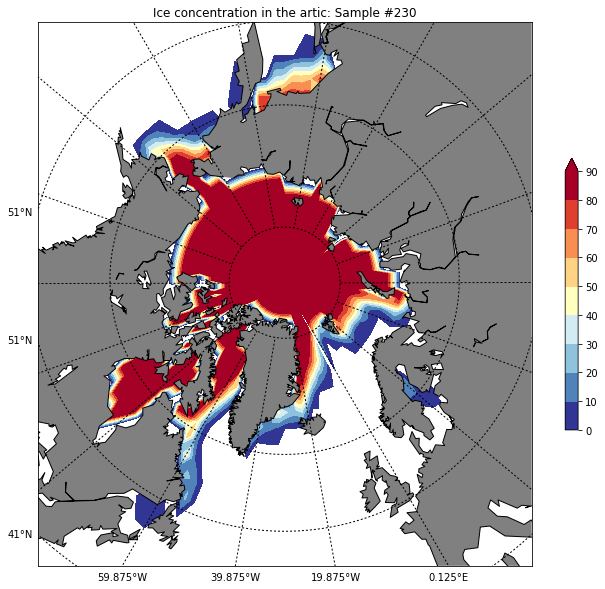

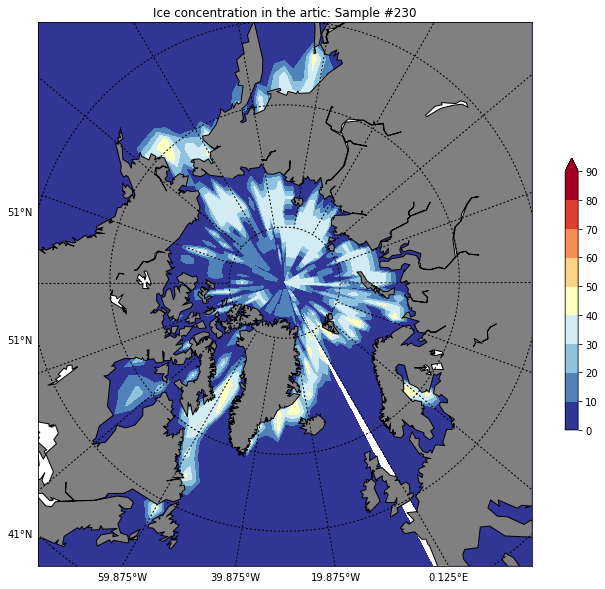

In [296]:
plot_contour_arctic_2D(conc2D)
plot_contour_arctic_2D(lbls)